In [1]:
ALPH = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [2]:
import random, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

In [3]:
# from caas_jupyter_tools import #display_dataframe_to_user

# If sympy is needed for Hill:
try:
    from sympy import Matrix
except Exception:
    Matrix = None


In [ ]:


# ----------------------------
# Shared metric functions
# ----------------------------
_eps = 1e-12
def _entropy_from_counts(counts, base=2):
    total = sum(counts.values())
    if total == 0: return 0.0
    H = 0.0
    for v in counts.values():
        p = v/total
        if p>0:
            H -= p * math.log(p, base)
    return H

def jensen_shannon_divergence(p_counts, q_counts, base=2):
    all_keys = set(p_counts.keys()) | set(q_counts.keys())
    Np, Nq = sum(p_counts.values()) or 1, sum(q_counts.values()) or 1
    m = {}
    for k in all_keys:
        m[k] = (p_counts.get(k,0)/Np + q_counts.get(k,0)/Nq) / 2.0
    kl_pm = 0.0; kl_qm = 0.0
    for k in all_keys:
        p = p_counts.get(k,0)/Np; q = q_counts.get(k,0)/Nq; mm = m[k]
        if p>0: kl_pm += p * math.log((p+_eps)/(mm+_eps), base)
        if q>0: kl_qm += q * math.log((q+_eps)/(mm+_eps), base)
    return 0.5*(kl_pm+kl_qm)

def mutual_information_pairs(pairs, base=2):
    N = len(pairs)
    if N==0: return 0.0
    joint = Counter(pairs)
    X = Counter(x for x,_ in pairs); Y = Counter(y for _,y in pairs)
    mi = 0.0
    for (x,y),n in joint.items():
        p_xy = n/N; p_x = X[x]/N; p_y = Y[y]/N
        mi += p_xy * math.log((p_xy+_eps)/(p_x*p_y+_eps), base)
    return mi

def confusion_jsd_avg(cipher_fun, plaintext, keyspace, sample_pairs=200, base=2):
    if len(keyspace) < 2: return 0.0
    total = 0.0; count = 0
    # If keyspace small, enumerate pairs; else sample
    for _ in range(sample_pairs):
        k1, k2 = random.sample(keyspace, 2)
        c1 = cipher_fun(plaintext, k1)
        c2 = cipher_fun(plaintext, k2)
        total += jensen_shannon_divergence(Counter(c1), Counter(c2), base=base)
        count += 1
    return total/count if count else 0.0

def diffusion_via_bigram_leakage(cipher_fun, plaintext, key, base=2):
    pt = "".join(ch for ch in plaintext.upper() if ch.isalnum())
    grams = [pt[i:i+2] for i in range(len(pt)-1)]
    if not grams:
        return 0.0
    C = cipher_fun(pt, key)
    L = min(len(grams), len(C))
    pairs = [(grams[i], C[i]) for i in range(L)]
    mi = mutual_information_pairs(pairs, base=base)
    H = _entropy_from_counts(Counter(grams), base=base)
    return 1.0 - (mi / H if H > 0 else 0.0)

def cdci_linear(alpha, C, D): return alpha*C + (1.0-alpha)*D

def compute_cdci_for_cipher(cipher_func, plaintexts, fixed_key, keyspace, alpha=0.5, sample_pairs=200):
    Cs = []; Ds = []
    for pt in plaintexts:
        C_val = confusion_jsd_avg(cipher_func, pt, keyspace, sample_pairs=sample_pairs)
        D_val = diffusion_via_bigram_leakage(cipher_func, pt, fixed_key)
        Cs.append(C_val); Ds.append(D_val)
    C_mean = float(np.mean(Cs)); D_mean = float(np.mean(Ds))
    return {'C':C_mean, 'D':D_mean, 'CDCI': cdci_linear(alpha, C_mean, D_mean), 'C_per_plain': Cs, 'D_per_plain': Ds}

# Generic helper metrics reused in each block
def fraction_changed(a, b):
    L = min(len(a), len(b))
    return sum(x!=y for x,y in zip(a[:L], b[:L])) / L if L else 0.0

def symbol_diffusion_index(cipher_func, plaintext, key, alphabet, trials=20):
    base_ct = cipher_func(plaintext, key)
    results = []
    pt_filtered = "".join(ch for ch in plaintext.upper() if ch.isalnum())
    if len(pt_filtered) == 0:
        return 0.0, 0.0
    for _ in range(trials):
        i = random.randrange(len(pt_filtered))
        new_char = random.choice([c for c in alphabet if c != pt_filtered[i]])
        P2 = pt_filtered[:i] + new_char + pt_filtered[i+1:]
        C2 = cipher_func(P2, key)
        results.append(fraction_changed(base_ct, C2))
    return float(np.mean(results)), float(np.std(results)) if len(results)>1 else 0.0

def compute_ksi(cipher_func, plaintext, key, key_variant):
    C1 = cipher_func(plaintext, key)
    C2 = cipher_func(plaintext, key_variant)
    return fraction_changed(C1, C2)

def compute_mi_from_plain_cipher_lists(plain_list, cipher_list):
    conc_plain = "".join( "".join(ch for ch in p.upper() if ch.isalnum()) for p in plain_list )
    conc_cipher = "".join(cipher_list)
    L = min(len(conc_plain), len(conc_cipher))
    pairs = list(zip(conc_plain[:L], conc_cipher[:L]))
    return mutual_information_pairs(pairs)

def compute_chi_entropy(ciphertexts, alphabet):
    text = "".join(ciphertexts)
    N = len(text)
    if N == 0: return 0.0, 0.0
    counts = Counter(text)
    expected = N / len(alphabet)
    chi2 = sum((counts[a] - expected)**2 / expected for a in alphabet)
    entropy = -sum((counts[a]/N) * math.log2(counts[a]/N) for a in counts if counts[a]>0)
    return chi2, entropy

def bootstrap_mi(pairs, n_boot=300, alpha=0.05):
    N = len(pairs)
    if N == 0: return 0.0, (0.0, 0.0)
    estimates = []
    for _ in range(n_boot):
        sample = [pairs[random.randrange(N)] for _ in range(N)]
        estimates.append(mutual_information_pairs(sample))
    estimates.sort()
    low = estimates[int((alpha/2)*n_boot)]
    high = estimates[int((1-alpha/2)*n_boot)]
    return np.mean(estimates), (low, high)

In [4]:
# ----------------------------
# 5) ADFGVX cipher (Polybius + Columnar)
# ----------------------------
ALPH36 = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
ADFGVX_CHARS = "ADFGVX"

def build_polybius_square(polykey):
    seen = []
    for ch in polykey.upper():
        if ch in ALPH36 and ch not in seen:
            seen.append(ch)
    for ch in ALPH36:
        if ch not in seen:
            seen.append(ch)
    coords = {}
    for idx, ch in enumerate(seen):
        coords[ch] = (ADFGVX_CHARS[idx//6], ADFGVX_CHARS[idx%6])
    return coords

def adfgvx_polybius_encode(text, polykey):
    coords = build_polybius_square(polykey)
    filtered = "".join(ch for ch in text.upper() if ch in ALPH36)
    return "".join("".join(coords[ch]) for ch in filtered)


def columnar_transposition_encrypt_string(s, key):
    n = len(key)
    rows = (len(s) + n - 1) // n
    padded = s + "X"*(rows*n - len(s))
    grid = [padded[i*n:(i+1)*n] for i in range(rows)]
    order = sorted(range(n), key=lambda i: key[i])
    return "".join("".join(row[j] for row in grid) for j in order)

def adfgvx_encrypt(plaintext, key_tuple):
    # key_tuple = (polykey36, trans_key)
    polykey, trans_key = key_tuple
    encoded = adfgvx_polybius_encode(plaintext, polykey)
    cipher = columnar_transposition_encrypt_string(encoded, trans_key)
    return cipher

def random_polykey36():
    chars = list(ALPH36); random.shuffle(chars); return "".join(chars)

def random_adfgvx_trans(min_len=4, max_len=8):
    length = random.randint(min_len, max_len)
    return "".join(random.choice(ALPH) for _ in range(length))

def perturb_adfgvx_key(key_tuple):
    pk, tk = key_tuple
    # small perturbation
    pk2 = list(pk); i,j = random.sample(range(36),2); pk2[i],pk2[j] = pk2[j],pk2[i]
    tk2 = list(tk)
    if len(tk2) >= 2:
        a,b = random.sample(range(len(tk2)),2); tk2[a],tk2[b] = tk2[b],tk2[a]
    return ("".join(pk2), "".join(tk2))
#fixed_poly="PH0QG64MEA1YL2NOFDZXKR3CVS5W7BJ9UTI8"
#fixed_trans="GERMAN"
def evaluate_adfgvx(num_texts=5, length=200,
                    fixed_poly="9Z3G0XM8Q4L7K2TVS5OJRUWB1H6CAYDFPEIN",
                    fixed_trans="CRYPTOGRAPHY", random_key_count=10, alpha=0.5):
    # prepare plaintexts (allow letters+digits)
    plaintexts = []
    for _ in range(num_texts):
        plaintexts.append("".join(random.choice(ALPH36) for _ in range(length)))
    plaintexts[0] = ("THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG0123456789" * 4)[:length]

    keyspace = [(random_polykey36(), random_adfgvx_trans()) for _ in range(120)]

    fixed_metrics = {}
    sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; ent_vals=[]; mi_boot=[]
    for pt in plaintexts:
        sm,ss = symbol_diffusion_index(lambda p,k: adfgvx_encrypt(p,k), pt, (fixed_poly, fixed_trans), ALPH36)
        sdi_vals.append(sm)
        pert = perturb_adfgvx_key((fixed_poly, fixed_trans)); ksi_vals.append(compute_ksi(lambda p,k: adfgvx_encrypt(p,k), pt, (fixed_poly, fixed_trans), pert))
        C = adfgvx_encrypt(pt, (fixed_poly, fixed_trans))
        # MI: align filtered plaintext and ciphertext (truncate)
        filtered_pt = "".join(ch for ch in pt.upper() if ch in ALPH36)
        pairs = list(zip(filtered_pt, C[:len(filtered_pt)]))
        mi_vals.append(mutual_information_pairs(pairs))
        chi,H = compute_chi_entropy([C], ADFGVX_CHARS); chi_vals.append(chi); ent_vals.append(H)
        mb,_ = bootstrap_mi(pairs, n_boot=150); mi_boot.append(mb)

    cdci_out = compute_cdci_for_cipher(lambda p,k: adfgvx_encrypt(p,k), plaintexts, (fixed_poly,fixed_trans), keyspace, alpha=alpha)
    fixed_metrics.update({
        'SDI_mean': np.mean(sdi_vals), 'KSI_mean': np.mean(ksi_vals), 'MI_mean': np.mean(mi_vals),
        'Chi2_mean': np.mean(chi_vals), 'Entropy_mean': np.mean(ent_vals), 'MI_boot_mean': np.mean(mi_boot),
        'C': cdci_out['C'], 'D': cdci_out['D'], 'CDCI': cdci_out['CDCI']
    })
    fixed_df = pd.DataFrame([fixed_metrics])

    random_keys = [(random_polykey36(), random_adfgvx_trans()) for _ in range(random_key_count)]
    rand_records=[]
    for rk in random_keys:
        sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; ent_vals=[]; mi_boot=[]
        for pt in plaintexts:
            sm,ss = symbol_diffusion_index(lambda p,k: adfgvx_encrypt(p,k), pt, rk, ALPH36)
            sdi_vals.append(sm); ksi_vals.append(compute_ksi(lambda p,k: adfgvx_encrypt(p,k), pt, rk, perturb_adfgvx_key(rk)))
            C = adfgvx_encrypt(pt, rk)
            filtered_pt = "".join(ch for ch in pt.upper() if ch in ALPH36)
            pairs = list(zip(filtered_pt, C[:len(filtered_pt)]))
            mi_vals.append(mutual_information_pairs(pairs))
            chi,H = compute_chi_entropy([C], ADFGVX_CHARS); chi_vals.append(chi); ent_vals.append(H)
            mb,_ = bootstrap_mi(pairs, n_boot=120); mi_boot.append(mb)
        cdci_out = compute_cdci_for_cipher(lambda p,k: adfgvx_encrypt(p,k), plaintexts, rk, keyspace, alpha=alpha)
        rand_records.append({
            'poly': rk[0][:8], 'trans': rk[1], 'SDI_mean': np.mean(sdi_vals), 'KSI_mean': np.mean(ksi_vals),
            'MI_mean': np.mean(mi_vals), 'Chi2_mean': np.mean(chi_vals), 'Entropy_mean': np.mean(ent_vals),
            'MI_boot_mean': np.mean(mi_boot), 'C': cdci_out['C'], 'D': cdci_out['D'], 'CDCI': cdci_out['CDCI']
        })
    random_df = pd.DataFrame(rand_records)
    summary = pd.DataFrame({
        'mode':['fixed','random_mean'],
        'SDI_mean':[fixed_metrics['SDI_mean'], random_df['SDI_mean'].mean()],
        'KSI_mean':[fixed_metrics['KSI_mean'], random_df['KSI_mean'].mean()],
        'MI_mean':[fixed_metrics['MI_mean'], random_df['MI_mean'].mean()],
        'Entropy_mean':[fixed_metrics['Entropy_mean'], random_df['Entropy_mean'].mean()],
        'CDCI':[fixed_metrics['CDCI'], random_df['CDCI'].mean()],
        'C_index':[fixed_metrics['C'], random_df['C'].mean()],
        'D_index':[fixed_metrics['D'], random_df['D'].mean()]
    })

    #display_dataframe_to_user("ADFGVX - Fixed", fixed_df)
    #display_dataframe_to_user("ADFGVX - Random", random_df)
    #display_dataframe_to_user("ADFGVX - Summary", summary)

    # plots
    x = np.arange(len(summary)); width=0.25
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(x-width, summary['CDCI'], width, label='CDCI')
    ax.bar(x, summary['C_index'], width, label='C-index')
    ax.bar(x+width, summary['D_index'], width, label='D-index')
    ax.set_xticks(x); ax.set_xticklabels(summary['mode']); ax.set_ylabel('Score'); ax.set_title('ADFGVX: CDCI / C / D'); ax.legend(); plt.show()

    # fixed_df.to_csv('../mnt/data/adfgvx_fixed.csv', index=False)
    # random_df.to_csv('../mnt/data/adfgvx_random.csv', index=False)
    # summary.to_csv('../mnt/adfgvx_summary.csv', index=False)
    print("ADFGVX saved to ./mnt/data/adfgvx_*.csv")
    return fixed_df, random_df, summary

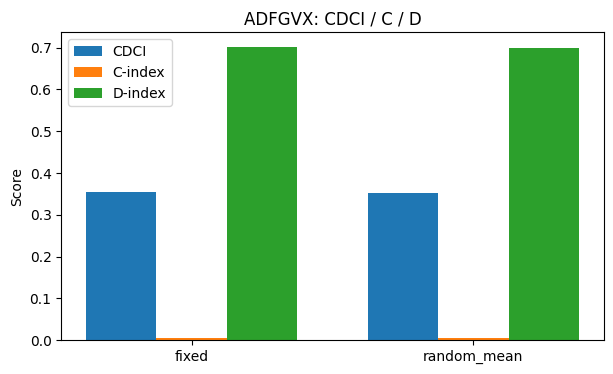

ADFGVX saved to ./mnt/data/adfgvx_*.csv


(   SDI_mean  KSI_mean   MI_mean  Chi2_mean  Entropy_mean  MI_boot_mean  \
 0  0.004358  0.189869  0.739827    5.75451      2.574579      1.126272   
 
           C         D      CDCI  
 0  0.005333  0.701703  0.353518  ,
        poly     trans  SDI_mean  KSI_mean   MI_mean  Chi2_mean  Entropy_mean  \
 0  B2JZSUAM   XJDMAIP  0.004339  0.276430  0.729849   6.512164      2.573182   
 1  UXCMOT9Q      DDTC  0.004039  0.403722  0.827089   5.750667      2.574505   
 2  UKXL1HZ0     QVUUJ  0.004547  0.403444  0.758930   5.770000      2.574109   
 3  Y4K93TFG    POQZYU  0.004436  0.330813  0.819419   4.236816      2.577129   
 4  R07BZ1MU     PWLPE  0.004322  0.294611  0.767907   5.850000      2.574007   
 5  WTF9BXQ0   MOPERKH  0.004317  0.261008  0.783923   6.498522      2.572865   
 6  ICHPW39Z  CRMPESZS  0.004403  0.265889  0.714733   6.903333      2.572224   
 7  8WD9KSCR   ENXRFLF  0.004287  0.296249  0.737204   5.605457      2.574693   
 8  H124BAKD   MHJQLZO  0.004021  0.281982  0.78

In [5]:
evaluate_adfgvx()

In [5]:
class ADFGVXCipher:
    def __init__(self, polykey, transkey):
        """ Initialize ADFGVX cipher with given keys """
        self.polykey = polykey
        self.transkey = transkey
        self.ALPH36 = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        self.alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        self.char_to_num = {char: i for i, char in enumerate(self.alphabet)}
        self.num_to_char = {i: char for i, char in enumerate(self.alphabet)}
        self.ADFGVX_CHARS = "ADFGVX"
        # Add a mapping for the ADFGVX output alphabet
        self.adfgvx_char_to_num = {char: i for i, char in enumerate(self.ADFGVX_CHARS)}
        self.adfgvx_num_to_char = {i: char for i, char in enumerate(self.ADFGVX_CHARS)}

    def build_polybius_square(self, polykey):
        """ Build Polybius square mapping from given polykey """
        seen = []
        for ch in polykey.upper():
            if ch in self.ALPH36 and ch not in seen:
                seen.append(ch)
        for ch in self.ALPH36:
            if ch not in seen:
                seen.append(ch)
        coords = {}
        for idx, ch in enumerate(seen):
            coords[ch] = (self.ADFGVX_CHARS[idx // 6], self.ADFGVX_CHARS[idx % 6])
        return coords

    def adfgvx_polybius_encode(self, text, polykey):
        """ Encode text using Polybius square with given polykey """
        coords = self.build_polybius_square(polykey)
        filtered = "".join(ch for ch in text.upper() if ch in self.ALPH36)
        return "".join("".join(coords[ch]) for ch in filtered)

    def columnar_transposition_encrypt_string(self, s, key):
        """ Encryption using columnar transposition with given key """
        n = len(key)
        rows = (len(s) + n - 1) // n
        padded = s + "X" * (rows * n - len(s))
        grid = [padded[i * n:(i + 1) * n] for i in range(rows)]
        order = sorted(range(n), key=lambda i: key[i])
        return "".join("".join(row[j] for row in grid) for j in order)

    def adfgvx_encrypt(self, plaintext):
        """ Encrypt plaintext using ADFGVX with instance keys """
        polykey, trans_key = (self.polykey, self.transkey)
        encoded = self.adfgvx_polybius_encode(plaintext, polykey)
        cipher = self.columnar_transposition_encrypt_string(encoded, trans_key)
        return cipher

    def encrypt(self, plaintext):
        """ Encrypt plaintext using ADFGVX with instance keys """
        cipher = self.adfgvx_encrypt(plaintext)
        return cipher



In [6]:
def measure_positional_diffusion(cipher_object, plaintext, num_trials=50):
    """
    Measures the positional predictability of changes in ciphertext.
    A lower score indicates more predictable changes (poor diffusion).
    """
    original_ciphertext = cipher_object.encrypt(plaintext)
    cipher_len = len(original_ciphertext)
    
    changed_positions_all = []
    
    for _ in range(num_trials):
        # Create an incremental plaintext change
        modified_plaintext = list(plaintext)
        pos = random.randint(0, len(plaintext) - 1)
        modified_plaintext[pos] = random.choice(cipher_object.alphabet)
        modified_plaintext = "".join(modified_plaintext)
        
        try:
            modified_ciphertext = cipher_object.encrypt(modified_plaintext)
        except Exception:
            continue
        
        changed_positions = [i for i, (c1, c2) in enumerate(zip(original_ciphertext, modified_ciphertext)) if c1 != c2]
        changed_positions_all.extend(changed_positions)
    
    if not changed_positions_all:
        return 0.0 # No changes were detected
    
    # Calculate a measure of distribution (e.g., variance of position indices)
    # A high variance indicates changes are scattered, low variance indicates clustering
    variance = np.var(changed_positions_all)
    
    # Normalize the score (you can adjust this formula)
    max_possible_variance = (cipher_len**2 - 1) / 12 # Variance of a uniform distribution
    normalized_score = variance / max_possible_variance
    
    return normalized_score

# Example Usage
# hill_cipher_obj = HillCipher(key="YOURKEY", n=3)
# score = measure_positional_diffusion(hill_cipher_obj, "ATTACKATDAWN")
# print(f"Positional Diffusion Score: {score:.2f}")

def measure_value_confusion(cipher_object, plaintext, num_trials=50):
    """
    Measures the predictability of the character values that change.
    A lower score indicates more predictable changes (poor confusion).
    """
    original_ciphertext = cipher_object.encrypt(plaintext)
    value_differences_all = []
    
    # Check if the cipher object has a transkey and use it for the key change
    original_key = getattr(cipher_object, 'transkey', None)
    if original_key is None:
        # Fallback for ciphers with a single key
        original_key = getattr(cipher_object, 'key', None)

    for _ in range(num_trials):
        # Create an incremental key change
        modified_key = list(original_key)
        pos = random.randint(0, len(original_key) - 1)
        # Use the correct alphabet for the key (usually A-Z)
        modified_key[pos] = random.choice(cipher_object.alphabet)
        modified_key = "".join(modified_key)
        
        try:
            # Create a new cipher object with the modified key
            # Pass the polykey unchanged since we're measuring transkey confusion
            modified_cipher_obj = ADFGVXCipher(polykey=cipher_object.polykey, transkey=modified_key)
            modified_ciphertext = modified_cipher_obj.encrypt(plaintext)
        except (ValueError, IndexError):
            continue
            
        # Calculate the numerical difference for changed characters
        diffs = [
            abs(cipher_object.adfgvx_char_to_num[c1] - cipher_object.adfgvx_char_to_num[c2])
            for c1, c2 in zip(original_ciphertext, modified_ciphertext) if c1 != c2
        ]
        value_differences_all.extend(diffs)
    
    if not value_differences_all:
        return 0.0 
        
    counts = Counter(value_differences_all)
    probabilities = np.array(list(counts.values())) / len(value_differences_all)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    max_entropy = np.log2(len(set(value_differences_all)))
    if max_entropy == 0:
        return 0.0
        
    normalized_entropy = entropy / max_entropy
    
    return normalized_entropy

In [6]:
# Example Usage
adfgvx_cipher_obj = ADFGVXCipher(polykey="9Z3G0XM8Q4L7K2TVS5OJRUWB1H6CAYDFPEIN", transkey="CRYPTOGRAPHY")
value_confusion_score = measure_value_confusion(adfgvx_cipher_obj, "AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality")
print(f"Character Value Confusion Score: {value_confusion_score:.2f}")


Character Value Confusion Score: 0.88


In [7]:
positional_difusion_score = measure_positional_diffusion(adfgvx_cipher_obj, "AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality")
print(f"Positional Diffusion Score: {positional_difusion_score:.2f}")

Positional Diffusion Score: 1.04


In [8]:

num = 2*value_confusion_score*positional_difusion_score
din = value_confusion_score + positional_difusion_score
DC = num / din
print(f"DC Score: {DC:.2f}")

DC Score: 0.95


In [7]:
adfgvx_cipher_obj_1 = ADFGVXCipher(polykey="9Z3G0XM8Q4L7K2TVS5OJRUWB1H6CAYDFPEIN", transkey="CRYPTOGRAPHY")
value_confusion_score = measure_value_confusion(adfgvx_cipher_obj_1, "AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality",num_trials=100)
print(f"Character Value Confusion Score: {value_confusion_score:.2f}")
positional_difusion_score = measure_positional_diffusion(adfgvx_cipher_obj_1, "AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality",num_trials=100)
print(f"Positional Diffusion Score: {positional_difusion_score:.2f}")
num = 2*value_confusion_score*positional_difusion_score
din = value_confusion_score + positional_difusion_score
DC = num / din
print(f"DC Score: {DC:.2f}")

Character Value Confusion Score: 0.88
Positional Diffusion Score: 0.91
DC Score: 0.89


In [ ]:
# plaintext - THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG0123456789
# Character Value Confusion Score: 0.94
# Positional Diffusion Score: 1.08

# plaintext - AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality
# Character Value Confusion Score: 0.88
# Positional Diffusion Score: 0.95

#plaintext - AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality
# Character Value Confusion Score: 0.88
# Positional Diffusion Score: 1.04
# DC Score: 0.95

# num_trial = 100
# Character Value Confusion Score: 0.88
# Positional Diffusion Score: 0.91
# DC Score: 0.89

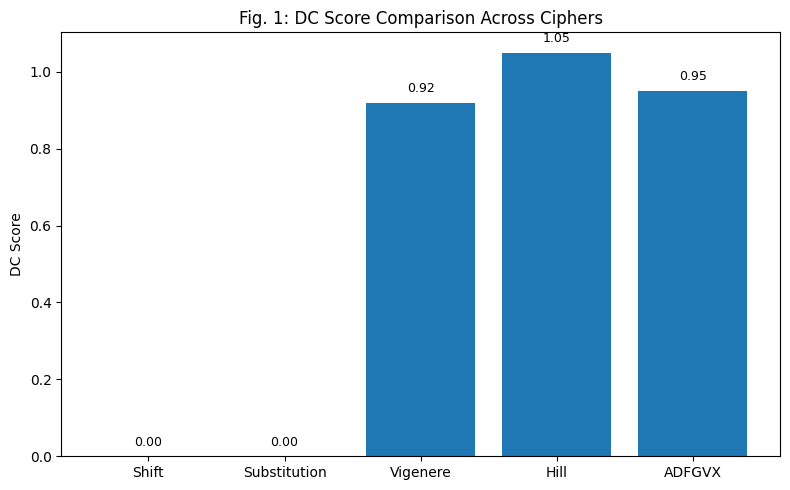

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# DC score data (from your measurements)
ciphers = ["Shift", "Substitution", "Vigenere", "Hill", "ADFGVX"]
dc_scores = [0.00, 0.00, 0.92, 1.05, 0.95]

# Optional: if you also want to show confusion/diffusion separately
confusion_scores = [0.00, 0.00, 0.90, 0.88, 0.88]
diffusion_scores = [0.78, 0.79, 0.93, 1.29, 1.04]

x = np.arange(len(ciphers))

plt.figure(figsize=(8, 5))
bars = plt.bar(x, dc_scores)

plt.xticks(x, ciphers)
plt.ylabel("DC Score")
plt.title("Fig. 1: DC Score Comparison Across Ciphers")

# Add value labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
# plt.savefig("cd_score_comparison.png", dpi=300)
plt.show()

In [ ]:
ciphers = ["Shift", "Substitution", "Vigenere", "Hill", "ADFGVX"]
dc_scores = [0.00, 0.00, 0.94, 1.05, 0.95]

# Optional: if you also want to show confusion/diffusion separately
confusion_scores = [0.00, 0.00, 0.90, 0.88, 0.88]
diffusion_scores = [0.78, 0.79, 0.93, 1.29, 1.04]

x = np.arange(len(ciphers))

plt.figure(figsize=(8, 5))
bars = plt.bar(x, dc_scores)

plt.xticks(x, ciphers)
plt.ylabel("DC Score")
plt.title("Fig. 1: DC Score Comparison Across Ciphers")

# Add value labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
# plt.savefig("cd_score_comparison.png", dpi=300)
plt.show()